# Examen Práctico

#### 01-3900 | Ciencia de datos | 2025

*Alumno*:

## Enunciado

Se tienen un dataset con datos de pacientes internados en un hospital (TP_Virus_Alumnos.csv). La clase de interes (1) refiere a la presencia de un virus. El virus tiene normalmente una gravedad leve/baja y el tratamiento suele ser invasivo. Datos como nombre y apellido han sido eliminados y los valores tanto en sangre (BLD), hormonales u otros análisis sobre reactivos han sido alterados en sus valores para preservar la privacidad. Se aclara que no se ha modificado su capacidad predictiva (Si es que la tienen).


Para su conocimiento: </BR>
Datos generales de Edad, Peso, Altura y condición laboral (Activo, Pasivo etc).
Datos medidos en hospital:</BR>
BLD: Sangre</BR>
LVL: Hormonales</BR>
REC: Otros análisis</BR>

Se pide obtener con los datos disponibles el mejor modelo posible que prediga la presencia o ausencia del virus.
Dado que el tratamiento es invasivo y la grevedad es moderada se requiere "atrapar" tantos "1" como sea posible y minimizar los falsos positivos para evitar que reciban un tratamiento de estas caracteristicas personas que no presentan el virus. Intente obtener el mejor modelo que maximice la métrica que considere correspondiente.



## Como desarrollar el exámen

A partir del dataset realice todas las acciones para poder llegar al mejor modelo, explique brevemente en los fundamentos de sus transformaciones o acciones en general.

La nota derivará de: </BR>
1.La calidad de la clasificación realizada</BR>
2.La fundamentación de los pasos realizados</BR>
3.Lo sencillo de llevar a producción el desarrollo</BR>



Los docentes evaluaran su clasificador utilizando un conjunto de datos del dataset "fuera de la caja" (out of the box, al que usted no tiene acceso). Para minimizar la posible diferencia entre su medición y la medición del docente recuerde y aplique conceptos de test, validación cruzada y evite los errores comunes de sesgo de selección y fuga de datos (Sklearn "10. Common pitfalls and recommended practices" disponible en "https://scikit-learn.org/stable/common_pitfalls.html)"   

Al final del notebook encontrará un bloque de código que lee la muestra adicional (a la que usted no tiene acceso) si PRODUCCION==True, en caso contrario solo lee una submuestra del conjunto original para validar que el código funciona. Desarrolle el notebook como considere para finalmente asignar el mejor clasificador o pipeline que usted haya obtenido remplazando en f_clf = None, None por su clasificador o pipeline. Si no utiliza un pipeline, implemente todas las transformaciones entre esa línea y la predicción final.

Persista modelos si realiza procesos que demoren (Mas de 10 minutos es mucho), alternativamente si quiere realizar búsquedas exhaustivas de hiperparametros o variables explicite el procedimiento y luego utilice los valores obtenidos para ajustar un clasificador/regresor y que los tiempos sean posibles en la corrección. Todas las herramientas vistas en clase están disponibles. Verifique que los docentes pueden ejecutar su clasificador / regresor usando el código adjunto y los datos "fuera de la caja" para validar la calidad su modelo.  

En materiales del MIEL/GIT se adjuntan un notebooks con algunas ideas para automatizar el proceso (Pipelines/Transformadores customizados).

## Evaluacion final - Docente + Alumno

Enunciado:

In [25]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

PRODUCCION = False
best_clf = None #Asignar aqui el mejor clasificador/pipeline posible (previamente entrenado si es necesario)

#Leemos el dataset de evaluación, simulando producción
if PRODUCCION==False:
    df = pd.read_csv("TP_Virus_Alumnos.csv")
    _, df = train_test_split(df, test_size=0.3, random_state=42)
else:
    df = pd.read_csv("TP_Virus_Evaluacion.csv")
#Dividimos en target y predictoras

X_prod = df.drop("target", axis=1)
y_prod = df["target"]

#Transformaciones en caso de no ser un pipeline completo. Preferiblemente, el mejor pipeline debe incluir todas las transformaciones necesarias.
#Si es pipeline ejecutar el fit (tener en cuenta el tiempo). Si mediante exploración / busqueda exhaustiva se encontró el mejor clasificador
#harcodear sus hiperparametros (Adjuntar código y explicación de como se encontró el mejor clasificador).

#Evaluación final
y_pred = best_clf.predict(X_prod)
print(classification_report(y_prod, y_pred))

AttributeError: 'NoneType' object has no attribute 'predict'

Fin del enunciado

---

# Solucion

### Carga de librerias


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, make_scorer, f1_score

# Importar distintos clasificadores para comparar
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Fijar semilla para reproducibilidad
SEED = 42
np.random.seed(SEED)


## Lectura del dataset y muestreo
Leer el CSV, separar un 30 % para “prueba” en modo desarrollo, o cargar directamente el archivo de evaluación si estamos en producción.

In [4]:
PRODUCCION = False

if not PRODUCCION:
    df = pd.read_csv("/content/TP_Virus_Alumnos.csv")
    # Partición para simular producción: 70% para entrenamiento, 30% para evaluación “desarrollador”
    df_train, df_eval = train_test_split(df, test_size=0.30, stratify=df["target"], random_state=SEED)
    df = df_eval.copy()    # df será la muestra de evaluación para validar que el pipeline funciona
else:
    df = pd.read_csv("TP_Virus_Evaluacion.csv")

# Separar X e y
X = df.drop("target", axis=1)
y = df["target"]

# Inspección rápida de las primeras filas
print("Dimensiones del dataset:", df.shape)
df.head()


Dimensiones del dataset: (1260, 15)


,Edad,Genero,Peso,Laboral,hijos,BLD01,REC1,REC2,REC3,REC4,REC5,BLD02,BLD03,LVL,target
3532,71.0,Masculino,85.784558,Inactivo,4,1.835205,3.316187,63.464743,73.234624,14.861363,90.182980,1.036246,-0.900866,105.989545,1
3221,39.0,NaN,88.417977,No_declara,2,3.137095,4.969963,64.331526,71.837088,14.320104,89.706096,2.166211,-0.050961,1000000.000000,1
1101,67.0,NaN,89.228598,Activo,3,-1.164004,4.818056,64.674380,72.352656,16.241628,92.185653,2.243227,2.881789,1000000.000000,1
303,37.0,Masculino,98.040612,Inactivo,4,1.652134,4.301773,63.960158,73.432508,15.800844,88.827282,0.684350,0.029287,1000000.000000,0
1910,33.0,Masculino,69.053571,Activo,3,-0.026018,3.107871,63.031812,74.699314,14.526854,88.991991,0.716040,1.069503,110.497259,0


##  Análisis exploratorio
* Confirmamos cuántas filas y columnas manejamos.
* Revisamos los tipos de datos (numéricos vs. categóricos).
* Esto nos ayudará a diseñar las transformaciones (por ejemplo, imputación y escalado para numéricos; OneHotEncoder para categóricos, etc.).

In [5]:
print("Total filas:", X.shape[0])
print("Total columnas (predictoras):", X.shape[1])

print("\nTipos de datos de cada columna:")
display(X.dtypes.value_counts())

print("\nCantidad de variables numéricas vs categóricas:")
display(X.select_dtypes(include=["int64","float64"]).shape[1], "numéricas")
display(X.select_dtypes(include=["object","category"]).shape[1], "categóricas")


Total filas: 1260
Total columnas (predictoras): 14

Tipos de datos de cada columna:


,count
float64,11
object,2
int64,1



Cantidad de variables numéricas vs categóricas:


12

'numéricas'

2

'categóricas'

### Revisión de valores faltantes y nulos

*  Obtenemos el número de nulos por columna y el porcentaje relativo.

* Si alguna columna presenta demasiados nulos (por ejemplo > 50 %), podríamos considerar eliminarla o buscar imputaciones muy específicas.

* Si la variable target llegara a tener nulos, debemos descartarlos o imputarlos, pero según el enunciado “Nula la variable target” implicaría que no esperamos nulos allí, porque sería información “fuera de caja”. **??** *revisar❗❗❗*



In [6]:
missing_counts = X.isnull().sum().sort_values(ascending=False)
missing_perc = (missing_counts / X.shape[0]) * 100

df_missing = pd.DataFrame({
    "nulos": missing_counts,
    "pct_nulos": missing_perc.round(2)
}).loc[missing_perc > 0]  # solo mostrar las columnas con > 0% nulos

print("Columnas con valores faltantes:")
display(df_missing)


Columnas con valores faltantes:


,nulos,pct_nulos
Genero,497,39.44
Edad,261,20.71
LVL,152,12.06


### Balance de clases
Vemos si la clase “1” (virus) es minoritaria. Dado que se pide “atrapar” el mayor número posible de 1, es probable que enfrentemos un desequilibrio de clases (por ejemplo, muchos ceros y pocos unos).

Esto implica usar estrategias para corregir el sesgo: ajustar class_weight en algunos clasificadores, usar muestreo estratificado, o técnicas de oversampling (SMOTE, etc.)—aunque en un entorno de producción hay que tener cuidado con overfitting.

Recuento absoluto por clase:
 target
0    748
1    512
Name: count, dtype: int64

Porcentaje por clase:
 target
0    59.37
1    40.63
Name: count, dtype: float64


<ipython-input-7-7b9243c61c3e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


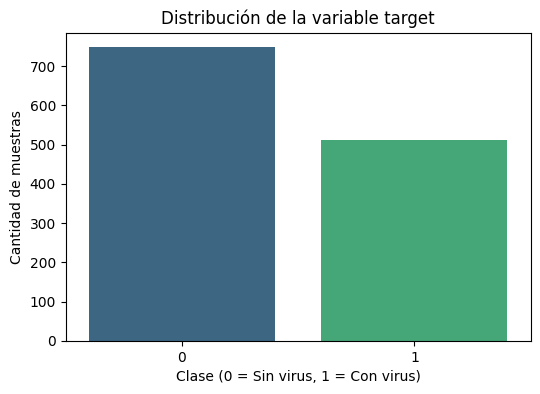

In [7]:
class_counts = y.value_counts()
print("Recuento absoluto por clase:\n", class_counts)
print("\nPorcentaje por clase:\n", (class_counts / len(y) * 100).round(2))

# Gráfico de barras para visualizar desbalance
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Distribución de la variable target")
plt.xlabel("Clase (0 = Sin virus, 1 = Con virus)")
plt.ylabel("Cantidad de muestras")
plt.show()


### Estadísticas descriptivas de variables numéricas
Con describe() obtenemos media, desviación, cuartiles, mínimos y máximos.

El boxplot nos ayuda a identificar valores atípicos que podrían requerir imputación especial o truncamiento (capping).

,count,mean,std,min,25%,50%,75%,max
Edad,999.0,37.994995,25.145169,0.000000,14.000000,36.000000,63.000000,79.000000
Peso,1260.0,73.377628,25.945874,8.934178,59.725282,80.906359,91.988987,128.850297
hijos,1260.0,1.750000,1.672145,0.000000,0.000000,1.000000,3.000000,5.000000
BLD01,1260.0,1.435533,1.147021,-2.482307,0.733732,1.432701,2.181932,5.171082
REC1,1260.0,4.030443,0.989272,0.890601,3.351790,4.023792,4.694832,7.512915
REC2,1260.0,64.015858,0.988247,60.891330,63.358738,63.996975,64.669890,67.019797
REC3,1260.0,72.975880,1.040543,69.564405,72.291619,72.976288,73.669316,76.200732
REC4,1260.0,15.020371,1.035905,11.788272,14.317643,15.013768,15.715302,18.071563
REC5,1260.0,90.011695,1.018066,86.891063,89.282248,90.005799,90.692906,92.988570
BLD02,1260.0,1.308621,0.985335,-2.283815,0.722529,1.344664,1.975156,4.717948


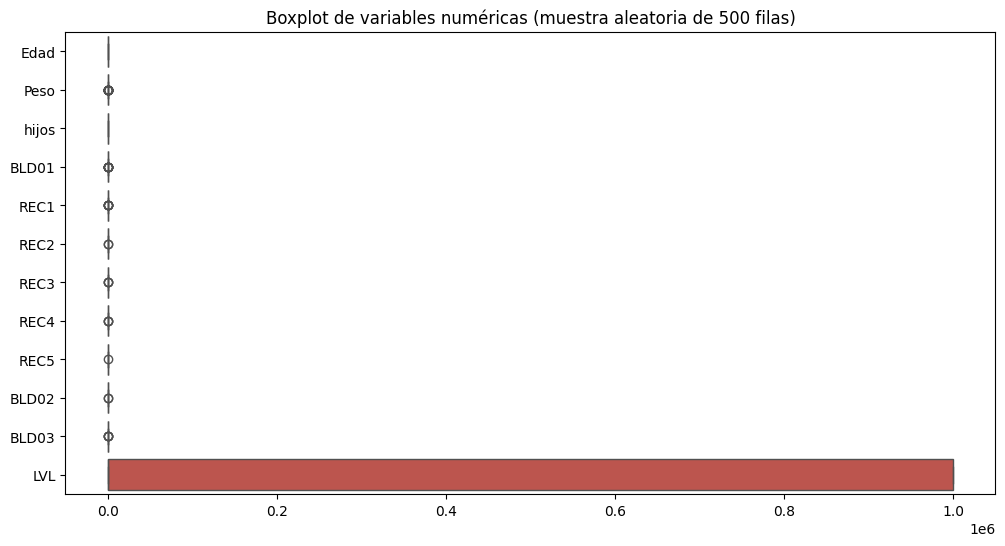

In [8]:
num_vars = X.select_dtypes(include=["int64","float64"]).columns

display(X[num_vars].describe().T)

# Boxplots para ver posibles valores extremos en algunas columnas
plt.figure(figsize=(12,6))
sns.boxplot(data=X[num_vars].sample(n=500, axis=0), orient="h", palette="coolwarm")
plt.title("Boxplot de variables numéricas (muestra aleatoria de 500 filas)")
plt.show()


### Correlaciones entre variables numéricas y con el target
Vemos qué variables numéricas tienen mayor relación lineal con la clase “1”.

Si detectamos variables muy correlacionadas entre sí (por ejemplo, > 0.9), podríamos descartar una para evitar redundancia.

Correlación ABSOLUTA de variables numéricas con el target:


,target
Peso,0.338109
BLD02,0.091003
BLD03,0.075844
BLD01,0.052757
REC4,0.023852
Edad,0.022404
REC1,0.015952
REC3,0.009177
LVL,0.002872
REC5,0.002152


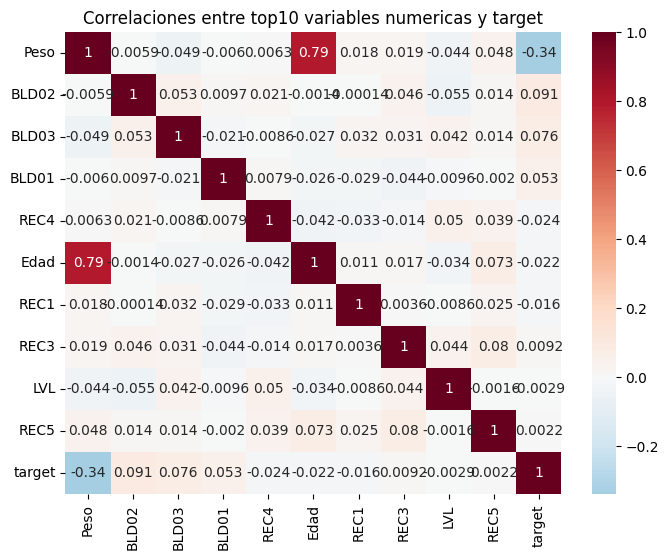

In [9]:
# Concatenamos X y y para incluir la correlación con target
df_corr = pd.concat([X[num_vars], y], axis=1)
corr_matrix = df_corr.corr()

# Mostrar correlación absoluta con target, ordenada de mayor a menor
corr_target = corr_matrix["target"].abs().sort_values(ascending=False).drop("target")
print("Correlación ABSOLUTA de variables numéricas con el target:")
display(corr_target)

# Heatmap de correlaciones entre las 10 variables numéricas más correlacionadas con target
top10 = corr_target.head(10).index
plt.figure(figsize=(8,6))
sns.heatmap(df_corr[top10.tolist() + ["target"]].corr(), annot=True, cmap="RdBu_r", center=0)
plt.title("Correlaciones entre top10 variables numericas y target")
plt.show()


## Preprocesamiento y pipeline básico
En esta sección vamos a preparar las transformaciones que harán falta sobre los datos. La idea es usar un `ColumnTransformer` para separar transformaciones de variables numéricas y categóricas, y luego un pipeline final que contenga:

    1. Imputación (por ejemplo, media/mediana para numéricas; valor más frecuente para categóricas).

    2. Escalado (solo para variables numéricas).

    3. Codificación (One-Hot) para variables categóricas.

    4. Reducir variables de baja varianza (opcional).

    5. Classifier (LogisticRegression, RandomForest, XGBoost, etc.).

In [16]:
# Split train/test (70% train, 30% test)
# -----------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

### Identificar variables numéricas vs categóricas
Guardamos en listas los nombres de columnas numéricas (num_features) y categóricas (cat_features).

Más adelante las usamos en el ColumnTransformer.

In [10]:
num_features = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object","category"]).columns.tolist()

print("Variables numéricas:", num_features)
print("Variables categóricas:", cat_features)


Variables numéricas: ['Edad', 'Peso', 'hijos', 'BLD01', 'REC1', 'REC2', 'REC3', 'REC4', 'REC5', 'BLD02', 'BLD03', 'LVL']
Variables categóricas: ['Genero', 'Laboral']


### Definir transformaciones para numéricas y categóricas
Imputación:

    Numéricas → mediana (más robusta frente a outliers).

    Categóricas → la categoría más frecuente.

Escalado: StandardScaler para centrar en 0 y desviación 1.

OneHotEncoder: codifica variables categóricas, ignorando categorías nuevas durante la inferencia (handle_unknown="ignore"). Si una variable categórica fuera binaria (solo dos categorías), drop='if_binary' elimina una de ellas para no generar variables linealmente dependientes.

Luego el ColumnTransformer aplicará cada pipeline solo a sus variables correspondientes.

In [11]:
# Para variables numéricas: imputar (mediana si hay outliers), luego escalar (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # si hay outliers, mediana es más robusta
    ("scaler", StandardScaler())
])

# Para variables categóricas: imputar la categoría más frecuente, luego OneHotEncoder (drop='if_binary' para evitar multicolinealidad)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

# ColumnTransformer para aplicar cada pipeline a las columnas correspondientes
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])


### Construir un pipeline completo con un clasificador dummy
Creamos pipeline_base que aplica las transformaciones y luego entrena una Regresión Logística con class_weight="balanced" (para corregir desbalance de clases).

Hacemos un fit/predict en el mismo conjunto solo para verificar que no haya errores de código. En la práctica, esto sobrestima el desempeño, pero nos asegura que el pipeline entra en “no entra en error”.

In [35]:
## NO EJECUTAR
from sklearn.naive_bayes import GaussianNB

# Ejemplo de clasificador: Logistic Regression (se podrá cambiar más adelante)
clf_base = LogisticRegression(random_state=SEED, max_iter=1000, class_weight="balanced")

# Pipeline completo: preprocesamiento + clasificador
pipeline_base = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", clf_base)
])

# Entrenamos el pipeline en el conjunto “df” (muestra de evaluación)
pipeline_base.fit(X, y)

# Predecir sobre el mismo X (solo para comprobar que no da errores)
y_pred_base = pipeline_base.predict(X)
print(classification_report(y, y_pred_base))


              precision    recall  f1-score   support

           0       0.79      0.74      0.77       748
           1       0.66      0.72      0.69       512

    accuracy                           0.73      1260
   macro avg       0.72      0.73      0.73      1260
weighted avg       0.74      0.73      0.73      1260



## Selección de métrica y estrategia de validación
Dado que queremos “atrapar” la mayor cantidad posible de positivos (clase 1) y al mismo tiempo minimizar falsos positivos, conviene centrarse en:

    Recall de la clase 1 (para no dejar pasar casos con virus).

    Precision de la clase 1 (para no marear con tratamientos invasivos a gente sana).

    O bien una métrica que combine ambos (por ejemplo, F1-score de la clase 1).


### Definir un scorer personalizado (F1 solo para la clase 1)
make_scorer(f1_score, pos_label=1) nos devuelve un objeto que calcula el F1-score exclusivamente para la clase “1”.

Durante el GridSearchCV, podremos usar este scorer para optimizar hiperparámetros que maximicen F1 en la detección de virus.

In [12]:
f1_class1 = make_scorer(f1_score, pos_label=1)

### Definir validación cruzada estratificada
Usamos validación cruzada estratificada con 5 pliegues, para mantener la proporción de cada clase en cada fold.

shuffle=True asegura que las muestras se mezclen antes del split; random_state=SEED hace reproducible la división.

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED) #42

## Búsqueda de hiperparámetros (GridSearchCV)
Ahora vamos a establecer un pipeline “genérico” donde reemplazaremos el clasificador según queramos probar varios modelos. A continuación te muestro cómo hacerlo para tres algoritmos distintos: Regresión Logística, Random Forest y XGBoost. Puedes elegir el que mejor funcione según la métrica (F1 clase 1).

    Nota: dado el límite de tiempo en Colab, recomendamos buscar hiperparámetros en un grid pequeño o, si prefieres, hacer una búsqueda en dos etapas (primero coarse, luego fine-tune). Aquí va un ejemplo de cada uno.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# Pipelines
# Configurar pipelines y parámetros para cada modelo
# -----------------------------------------------------------

models_and_params = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "clf__n_neighbors": [3, 5, 7],
            "clf__weights": ["uniform", "distance"]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10],
            "clf__class_weight": ["balanced", "balanced_subsample"]
        }
    },
    "NaiveBayes": {
        "model": GaussianNB(),
        "params": {
            # GaussianNB apenas requiere ajustar var_smoothing
            "clf__var_smoothing": [1e-9, 1e-8, 1e-7]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "clf__max_depth": [None, 10, 20],
            "clf__min_samples_split": [2, 5],
            "clf__class_weight": ["balanced", None]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, solver="liblinear", max_iter=1000),
        "params": {
            "clf__penalty": ["l1", "l2"],
            "clf__C": [0.1, 1, 10],
            "clf__class_weight": ["balanced", None]
        }
    }
}

# -----------------------------------------------------------
# Para cada clasificador: armar Pipeline, hacer GridSearchCV y guardar resultados
# -----------------------------------------------------------

results = []

for name, mp in models_and_params.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("clf", mp["model"])
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=mp["params"],
        scoring=f1_class1,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    print(f"\n--- Ajustando {name} ---")
    grid.fit(X_train, y_train)

    # Esto me lo guarddop por que me dio mejor pero esta villero no se hace asi
    if name == "RandomForest":
      grid_rf = grid

    print(f"Mejores parámetros para {name}: {grid.best_params_}")
    print(f"Mejor F1 (clase 1) para {name}: {grid.best_score_:.4f}\n")

    results.append({
        "Modelo": name,
        "Best_F1_1": grid.best_score_,
        "Best_Params": grid.best_params_
    })


--- Ajustando KNN ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros para KNN: {'clf__n_neighbors': 5, 'clf__weights': 'uniform'}
Mejor F1 (clase 1) para KNN: 0.5915


--- Ajustando RandomForest ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores parámetros para RandomForest: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__n_estimators': 100}
Mejor F1 (clase 1) para RandomForest: 0.7122


--- Ajustando NaiveBayes ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mejores parámetros para NaiveBayes: {'clf__var_smoothing': 1e-09}
Mejor F1 (clase 1) para NaiveBayes: 0.6112


--- Ajustando DecisionTree ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros para DecisionTree: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__min_samples_split': 2}
Mejor F1 (clase 1) para DecisionTree: 0.6514


--- Ajustando LogisticRegression ---
Fitting 5 folds for each of 12 candidates, total

## Comparación de resultados y elección del mejor modelo
Tras ejecutar los tres GridSearchCV, comparamos las mejores puntuaciones (best_score_) de cada uno.

Decidimos quedarnos con el modelo que maximice F1 en la clase 1 (que captura mejor el compromiso entre precision y recall para detectar virus).

Si hubiera dos modelos con valores muy cercanos, podríamos comparar sus curvas de precision-recall o incluso medir roc_auc_score.

In [18]:
results_df = pd.DataFrame(results).sort_values(by="Best_F1_1", ascending=False)
print("=== Resumen comparativo de F1 (clase 1) ===")
display(results_df)


=== Resumen comparativo de F1 (clase 1) ===


,Modelo,Best_F1_1,Best_Params
1,RandomForest,0.712249,"{'clf__class_weight': 'balanced', 'clf__max_de..."
4,LogisticRegression,0.676464,"{'clf__C': 0.1, 'clf__class_weight': 'balanced..."
3,DecisionTree,0.651400,"{'clf__class_weight': None, 'clf__max_depth': ..."
2,NaiveBayes,0.611173,{'clf__var_smoothing': 1e-09}
0,KNN,0.591533,"{'clf__n_neighbors': 5, 'clf__weights': 'unifo..."


## Evaluación final sobre el conjunto de evaluación “out-of-the-box”
Ahora que tenemos el mejor modelo (best_clf), hay que:

    Reentrenarlo con todo el dataset (si PRODUCCION=False, idealmente lo hubiéramos entrenado en df_train completo).

    Si PRODUCCION=True, directamente hacemos predict sobre df (porque ya es el dataset de evaluación “real”).

    Calcular el reporte de clasificación (classification_report) para ver precision, recall y F1 en cada clase, además de accuracy global.

### Reentrenamiento con todo el set (modo NO producción)
reentrenamos mejor modelo con todo el dataset original (TP_Virus_Alumnos.csv), usando los mejores hiperparámetros encontrados. Así tenemos el modelo “definitivo” antes de evaluarlo “fuera de caja”.

Modo PRODUCCIÓN: X y y ya vienen de “TP_Virus_Evaluacion.csv”, por lo que grid_xgb.best_estimator_ está entrenado en esos datos y solo hace falta asignarlo a best_clf.


In [24]:
# **** Entrenar best_clf sobre todo df_train (cuando PRODUCCION=False) ****
if not PRODUCCION:
    # Carga completa del dataset original
    df_full = pd.read_csv("TP_Virus_Alumnos.csv")
    X_full = df_full.drop("target", axis=1)
    y_full = df_full["target"]

    # Supongamos que 'grid_rf' es tu GridSearchCV para RandomForest
    best_params = grid_rf.best_params_

    # Reconstruimos el RandomForest con esos parámetros
    best_rf = RandomForestClassifier(
        random_state=SEED,
        n_estimators=best_params["clf__n_estimators"],
        max_depth=best_params["clf__max_depth"],
        class_weight=best_params["clf__class_weight"]
    )

    # Pipeline final: preprocesamiento + RandomForest
    best_clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("clf", best_rf)
    ])
    best_clf.fit(X_full, y_full)

else:
    # En modo producción, suponiendo que 'grid_rf' ya se entrenó sobre X_prod/y_prod:
    best_clf = grid_rf.best_estimator_



### Predicción y reporte de clasificación final

In [26]:
# Si PRODUCCION=False → X, y estábamos usando df_eval (muestra del 30%)
# Si PRODUCCION=True  → X, y vienen del TP_Virus_Evaluacion real.

y_pred = best_clf.predict(X)
print("Reporte de clasificación final (muestra evaluación):")
print(classification_report(y, y_pred, digits=4))


Reporte de clasificación final (muestra evaluación):
              precision    recall  f1-score   support

           0     0.8872    0.9465    0.9159       748
           1     0.9134    0.8242    0.8665       512

    accuracy                         0.8968      1260
   macro avg     0.9003    0.8854    0.8912      1260
weighted avg     0.8979    0.8968    0.8958      1260



## Analizar curvas Precision–Recall y ROC
PR AUC: el área bajo la curva precision–recall. Para desequilibrio de clases, es más informativo que ROC AUC, porque se centra en la clase positiva.

ROC AUC: área bajo la curva TPR vs FPR.

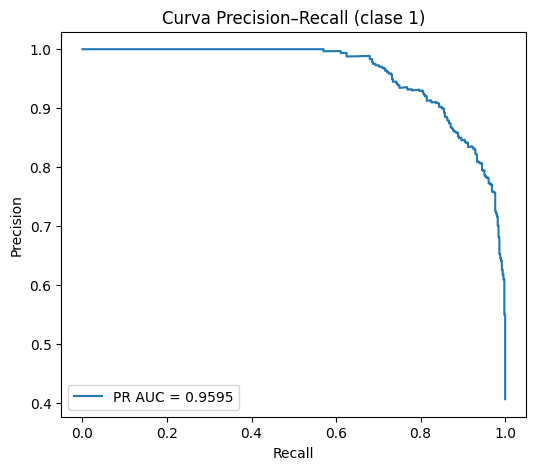

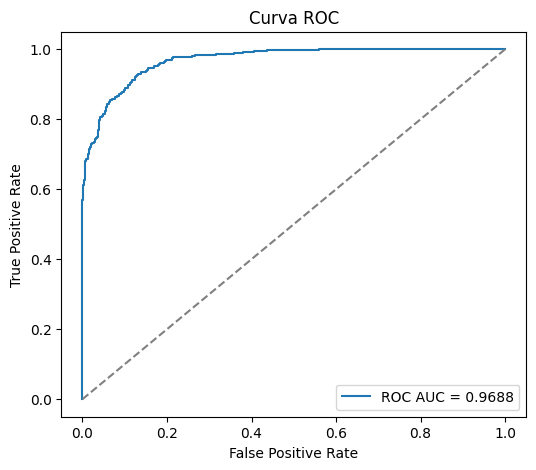

In [27]:
# **** BLOQUE 9: Curvas Precision–Recall y ROC ****
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Obtener probabilidades (score) para la clase 1
y_scores = best_clf.predict_proba(X)[:, 1]

# Curva Precision–Recall
precision, recall, thresholds_pr = precision_recall_curve(y, y_scores, pos_label=1)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall (clase 1)")
plt.legend()
plt.show()

# Curva ROC
fpr, tpr, thresholds_roc = roc_curve(y, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()


---

# **Como Guardar modelo**

Si el modelo tarda más de 10 minutos en entrenar, conviene guardarlo con joblib o pickle. Esto permite recargarlo sin volver a ajustarlo.
```
import joblib

# Nombre de archivo donde persistiremos el pipeline
joblib.dump(best_clf, "best_clf_virus.pkl")
print("Modelo guardado en best_clf_virus.pkl")
```
Con joblib.dump, se guarda el Pipeline completo (incluye preprocesamiento y clasificador).

Si más adelante lo queremos usar:

    loaded_clf = joblib.load("best_clf_virus.pkl")
    y_pred_new = loaded_clf.predict(X_new)
